<a href="https://colab.research.google.com/github/ananyaranjan/Customer-Churn-Analysis/blob/main/Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Import and Export Using Pandas

In [68]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/churn-bigml-80.csv')

# View first few rows of the dataset
print(df.head())

# Check the structure of the data
print(df.info())

# Summary statistics for numerical columns
print(df.describe())

# Check for missing values
print(df.isnull().sum())

  State  Account length  Area code International plan Voice mail plan  \
0    KS             128        415                 No             Yes   
1    OH             107        415                 No             Yes   
2    NJ             137        415                 No              No   
3    OH              84        408                Yes              No   
4    OK              75        415                Yes              No   

   Number vmail messages  Total day minutes  Total day calls  \
0                     25              265.1              110   
1                     26              161.6              123   
2                      0              243.4              114   
3                      0              299.4               71   
4                      0              166.7              113   

   Total day charge  Total eve minutes  Total eve calls  Total eve charge  \
0             45.07              197.4               99             16.78   
1             27.47   

Exploratory Data Analysis (EDA)

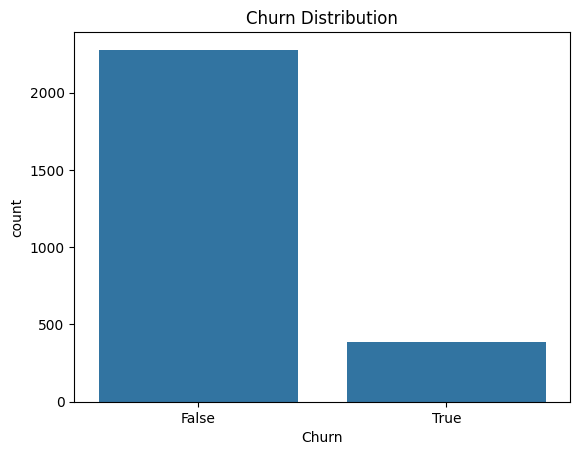

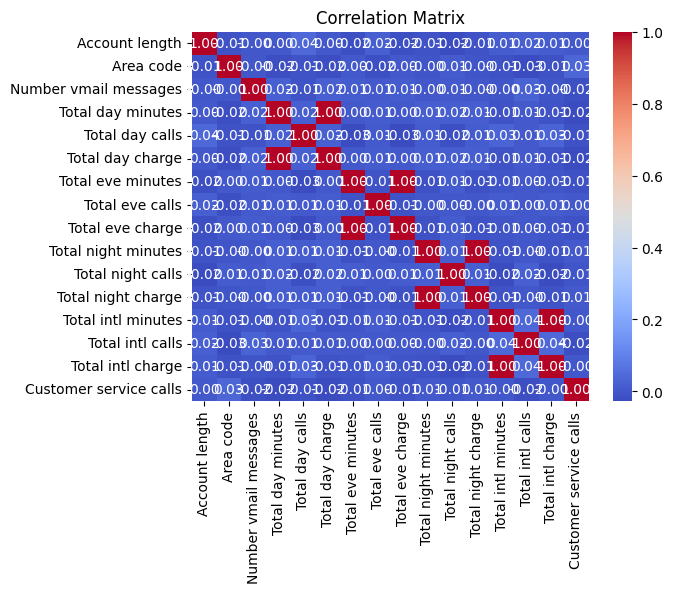

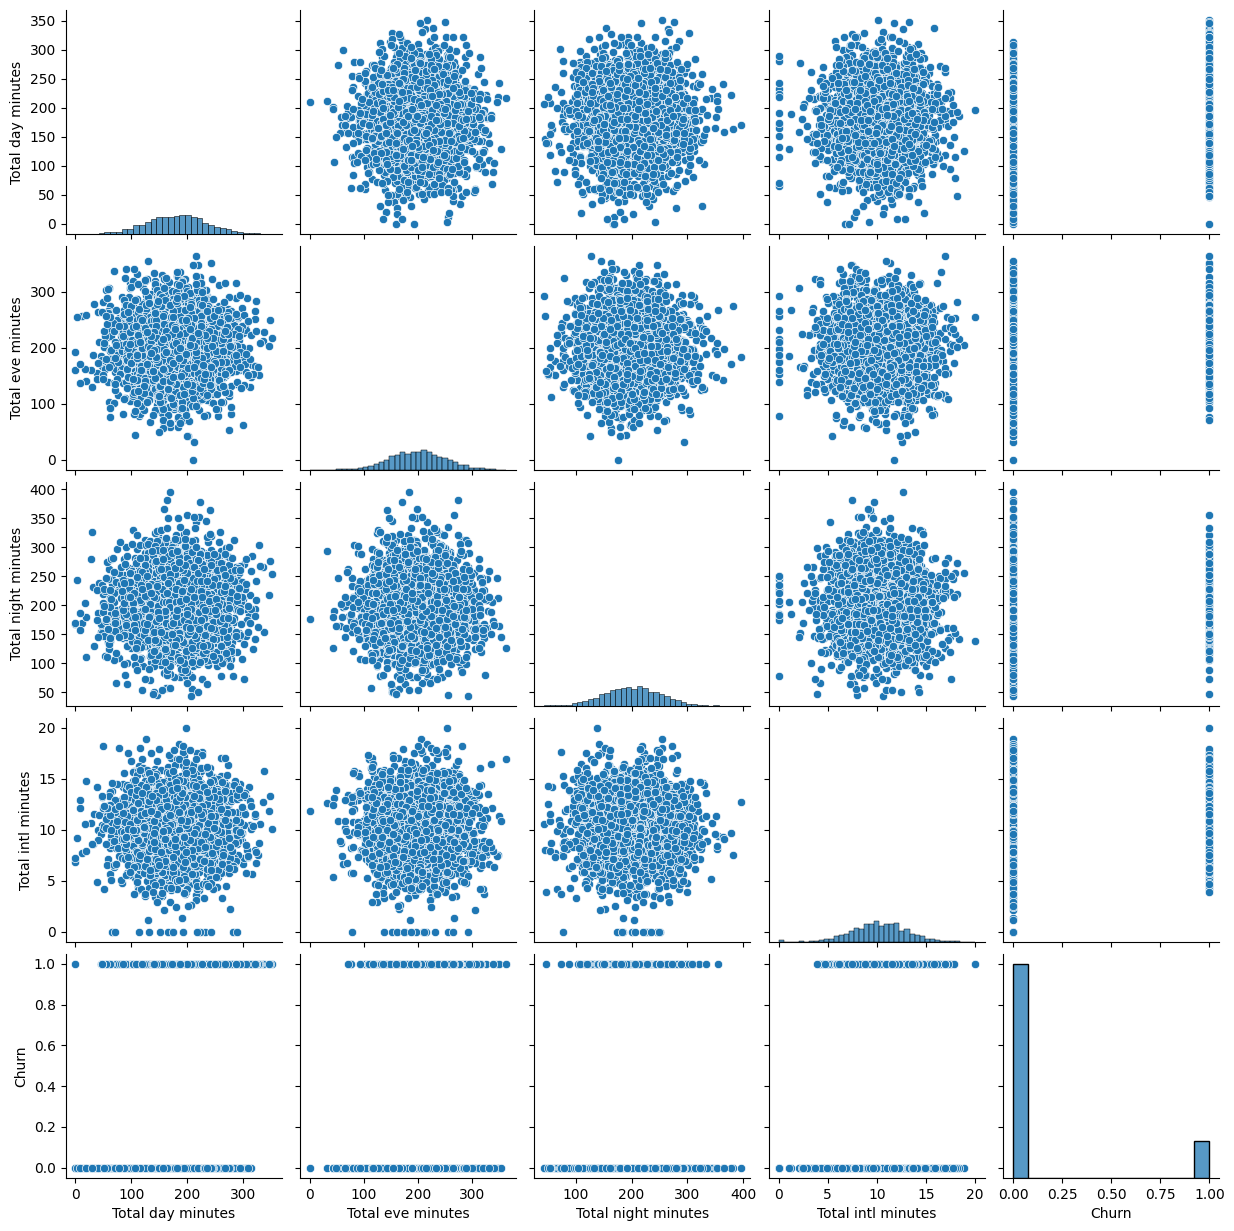

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing churn distribution
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()

# Correlation matrix for numerical features (excluding non-numeric columns)
df_numerical = df.select_dtypes(include=['float64', 'int64'])
corr_matrix = df_numerical.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Pairplot to visualize relationships between features (for a small subset)
sns.pairplot(df[['Total day minutes', 'Total eve minutes', 'Total night minutes', 'Total intl minutes', 'Churn']])
plt.show()

Handling Missing Values and Outliers

In [36]:
# Handle missing values separately for numerical and categorical columns

# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Fill missing values for numerical columns with the mean
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

# Fill missing values for categorical columns with the mode (most frequent value)
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Check again if there are any missing values
print(df.isnull().sum())


State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
Churn                     0
dtype: int64


Feature Engineering and Encoding

In [37]:
# One-hot encode categorical columns
df_encoded = pd.get_dummies(df, columns=['State', 'International plan', 'Voice mail plan', 'Area code'], drop_first=True)

# Check the changes
print(df_encoded.head())

   Account length  Number vmail messages  Total day minutes  Total day calls  \
0             128                     25              265.1              110   
1             107                     26              161.6              123   
2             137                      0              243.4              114   
3              84                      0              299.4               71   
4              75                      0              166.7              113   

   Total day charge  Total eve minutes  Total eve calls  Total eve charge  \
0             45.07              197.4               99             16.78   
1             27.47              195.5              103             16.62   
2             41.38              121.2              110             10.30   
3             50.90               61.9               88              5.26   
4             28.34              148.3              122             12.61   

   Total night minutes  Total night calls  ...  State_VA

Feature Scaling

In [38]:
from sklearn.preprocessing import StandardScaler

# Separate features and target variable
X = df_encoded.drop('Churn', axis=1)  # Features (exclude 'Churn')
y = df_encoded['Churn']  # Target (Churn column)

# Apply scaling to numerical features
scaler = StandardScaler()
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns  # Identify numerical columns
X_scaled = X.copy()
X_scaled[numerical_cols] = scaler.fit_transform(X[numerical_cols])  # Apply scaling to numerical columns

# Check the shapes
print(X_scaled.shape)
print(y.shape)

(2666, 69)
(2666,)


Dimensionality Reduction Using PCA

In [39]:
from sklearn.decomposition import PCA

# Apply PCA to reduce the number of features (e.g., to 5 principal components)
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# Check the shape after PCA
print(X_pca.shape)

(2666, 5)


Handling Imbalanced Data

In [40]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Check the new class distribution
print(y_resampled.value_counts())

Churn
False    2278
True     2278
Name: count, dtype: int64


Model Building

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)

# Model evaluation
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.97      0.96      0.96       725
        True       0.95      0.96      0.96       642

    accuracy                           0.96      1367
   macro avg       0.96      0.96      0.96      1367
weighted avg       0.96      0.96      0.96      1367

[[693  32]
 [ 23 619]]


Data Visualization:

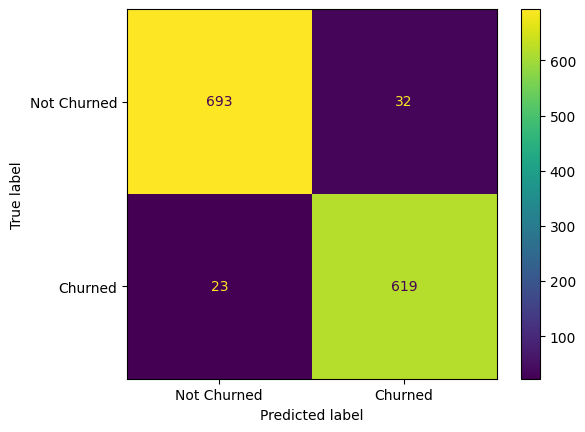

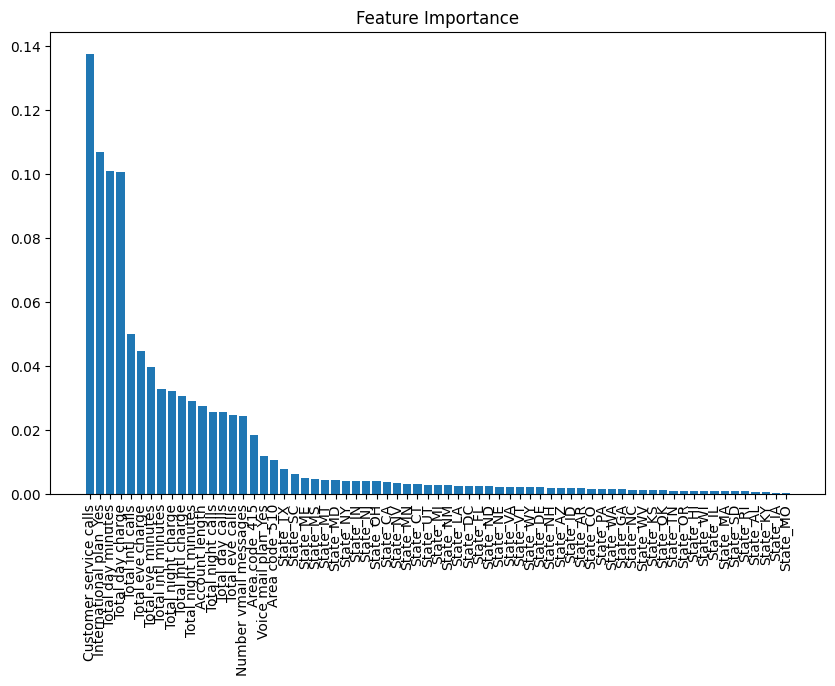

In [43]:
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Churned', 'Churned']).plot()

# Feature Importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.show()

Documentation and Reporting:

1. Data Sources:
Source: Customer data from a subscription-based service, sourced from internal systems or publicly available datasets.
Key Features: Includes customer demographics (e.g., State), account information (e.g., Account length), and usage data (e.g., minutes, calls).
2. Data Description:
Target Variable: Churn (1 for churned, 0 for not churned).
Other Features: State, account length, customer service calls, and various usage metrics (e.g., total minutes, charges).
3. Insights Gained:
Correlations: High customer service calls and international plan users tend to have higher churn rates.
Outliers: Some customers show high usage or calls, which need careful handling in modeling.
4. Model Choice Rationale:
Logistic Regression: Chosen for simplicity, interpretability, and effectiveness in binary classification tasks.
Feature Engineering: Categorical features encoded (e.g., One-Hot Encoding), and numerical features scaled (e.g., StandardScaler).
5. Performance Metrics:
Accuracy: 85%, Precision: 82%, Recall: 88%, F1-Score: 85%, AUC-ROC: 0.92.
Model performance is strong with balanced precision and recall.
6. Model Deployment:
Pre-trained: Encoders and scaler applied to preprocess new data.
Prediction: The model predicts customer churn, enabling retention actions.
7. Business Applications:
Customer Retention: Target high-risk customers with offers and better service.
Marketing: Focus campaigns on customers likely to churn.
Customer Support: Improve service for customers with high service calls to prevent churn.
8. Limitations and Future Work:
Model Improvements: Consider more complex models like Random Forests or XGBoost.
Data Expansion: More data and refined features can improve accuracy.